In [20]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s e

In [21]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=3ff154939e28382adeda34786662d6f4af2cad90e6f747c540b5cf734fb23c04
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
import cv2
from PIL import Image

In [2]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [3]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [4]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [5]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [6]:
combined_data.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [7]:
combined_data['diagnosis'].value_counts()

,count
diagnosis,
0,1805
2,999
1,370
4,295
3,193


In [8]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

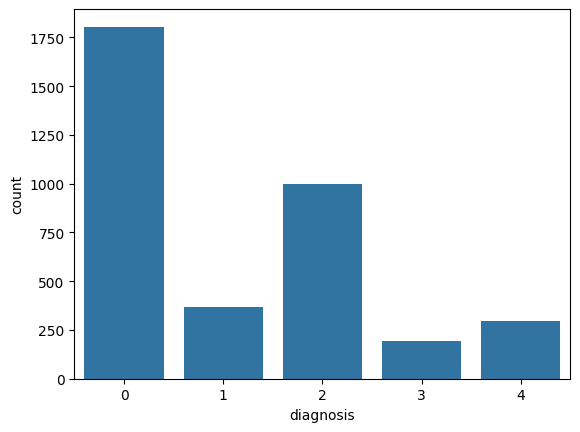

In [9]:
sns.countplot(combined_data,x='diagnosis')

In [10]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [11]:
target_size=500

In [12]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

,id_code,diagnosis
0,ef5155990874,0
1,24de56d433cd,0
2,81914ceb4e74,0
3,a1b28bcbce00,0
4,c365c598ad4e,0


In [13]:
downsampled_df['diagnosis'].value_counts()

,count
diagnosis,
0,500
2,500
1,370
4,295
3,193


In [14]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [15]:

path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [16]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [17]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


In [18]:
size=800

In [19]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [20]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

,id_code,diagnosis
0,20170220085833145.jpg,0
1,20170329074906288.jpg,0
2,007-1981-100.jpg,0
3,007-0795-000.jpg,0
4,20170226223624346.jpg,0


In [21]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

In [22]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [23]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [24]:
class DRDatasetFromDF(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['id_code']
        label = row['diagnosis']

        #  First, try the image_id as is (in case it already has extension)
        image_path = os.path.join(self.images_dir, image_id)
        found = os.path.exists(image_path)

        # If not found, try adding extensions
        if not found:
            for ext in ['.png', '.jpg', '.jpeg']:
                image_path = os.path.join(self.images_dir, f"{image_id}{ext}")
                if os.path.exists(image_path):
                    found = True
                    break

        if not found:
            # List available files for debugging
            available_files = os.listdir(self.images_dir)[:10]  # Show first 10 files
            raise FileNotFoundError(f"Image not found: {image_id}\nChecked path: {self.images_dir}\nFirst 10 files in directory: {available_files}")

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Green channel
        green = img[:, :, 1]

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        green_clahe = clahe.apply(green)

        # Gaussian Blur
        blurred = cv2.GaussianBlur(green_clahe, (5, 5), 0)

        # Convert to PIL
        img_pil = Image.fromarray(blurred)

        # Apply transform
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)

        return img_tensor, label


In [25]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomErasing(p=0.3)
])

In [26]:

train_dataset = DRDatasetFromDF(train_df, images_dir="combined_images", transform=transform)
val_dataset   = DRDatasetFromDF(val_df, images_dir="combined_images", transform=transform)
test_dataset  = DRDatasetFromDF(test_df, images_dir="combined_images", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.optim import Adam
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', in_channels=1, num_classes=5)
model._dropout = nn.Dropout(0.5)
original_fc = model._fc
model._fc = nn.Sequential(
    nn.Dropout(0.5),
    original_fc,
    nn.Dropout(0.3)
)
model.to(device)

# Define class weights (ordered by class index 0 → 4)
class_weights = torch.tensor([0.7, 1.0, 1.0, 1.8, 1.0], dtype=torch.float).to(device)

Loaded pretrained weights for efficientnet-b0


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [29]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from efficientnet_pytorch import EfficientNet
from PIL import Image
import os

🔎 Image 0 - Predicted class: 1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


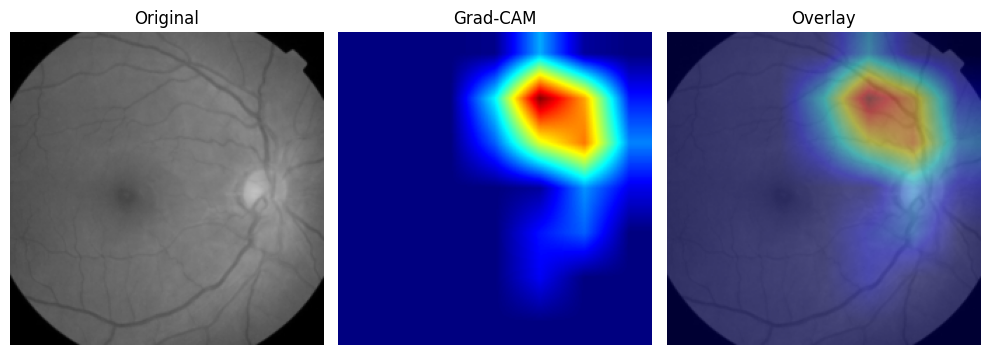

🔎 Image 1 - Predicted class: 2


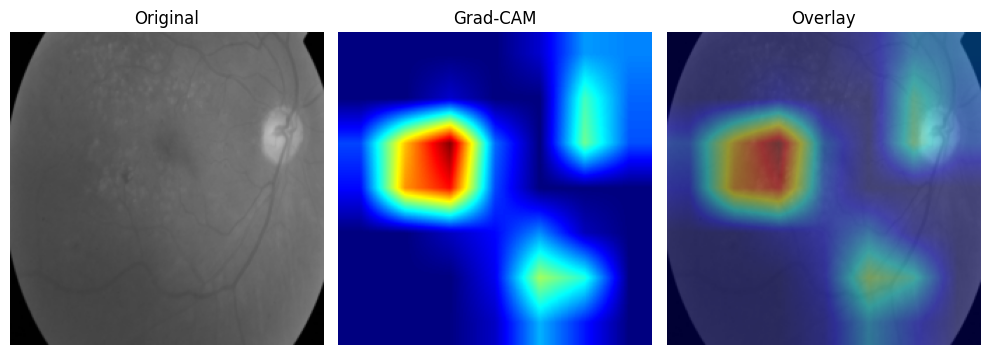

🔎 Image 2 - Predicted class: 2


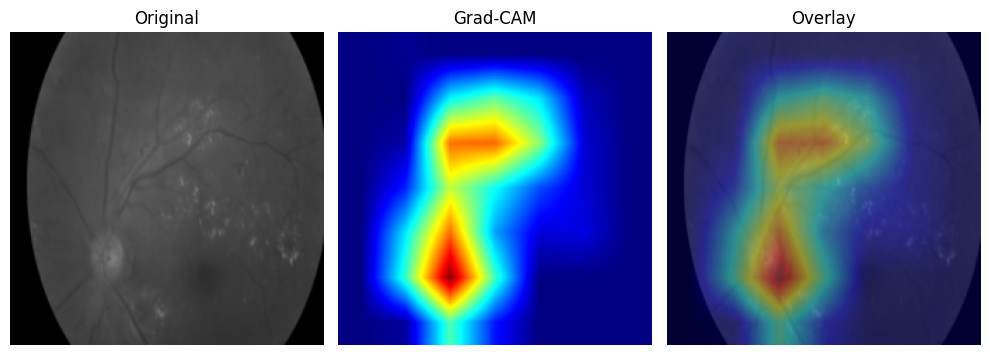

🔎 Image 3 - Predicted class: 1


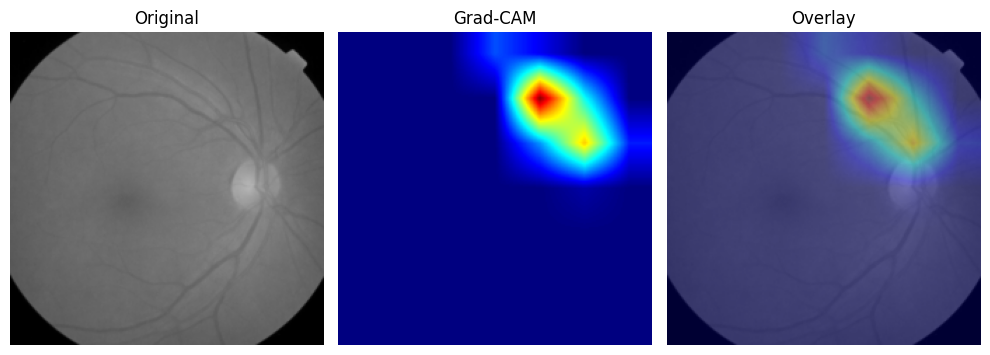

🔎 Image 4 - Predicted class: 2


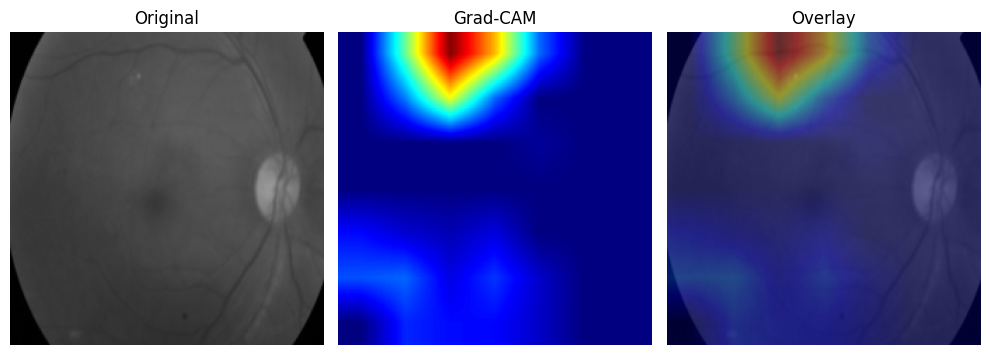

🔎 Image 5 - Predicted class: 4


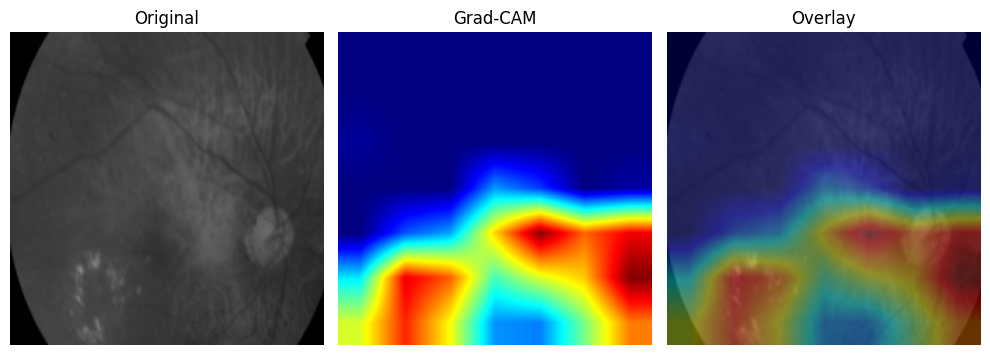

🔎 Image 6 - Predicted class: 2


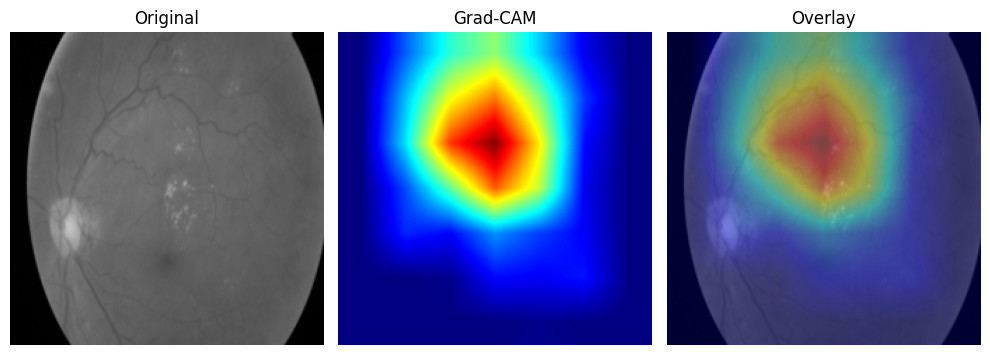

In [30]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from efficientnet_pytorch import EfficientNet
from PIL import Image
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Load the trained model state dictionary
model.load_state_dict(torch.load("/content/best_model (4) (1).pth", map_location=device))
model.to(device)
model.eval()

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        return cam


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Define the target layer for Grad-CAM
target_layer = model._blocks[-1]._project_conv

# Create a GradCAM instance
grad_cam_instance = GradCAM(model, target_layer)


for idx in range(7):
    image_id = test_df.iloc[idx]['id_code']

    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join('combined_images', image_id + ext)
        if os.path.exists(path):
            image_path = path
            break
    else: # If loop completes without finding file
        print(f"Image not found for ID: {image_id}")
        continue


    original_image = Image.open(image_path).convert("L")
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        print(f"🔎 Image {idx} - Predicted class: {pred_class}")

    # Grad-CAM
    cam = grad_cam_instance(input_tensor, class_idx=pred_class)


    cam = cv2.resize(cam, (224, 224))
    cam = (cam * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    image_np = input_tensor.squeeze().cpu().numpy()
    image_np = (image_np * 0.5 + 0.5) * 255
    image_np = image_np.astype(np.uint8)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    # Convert BGR to RGB for matplotlib display
    plt.imshow(image_np[..., ::-1])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    # Convert BGR to RGB for matplotlib display
    plt.imshow(heatmap[..., ::-1])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    # Convert BGR to RGB for matplotlib display
    plt.imshow(overlay[..., ::-1])
    plt.axis('off')

    plt.tight_layout()
    plt.show()